In [5]:
import QUANTAXIS as QA

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 14  # 字体大小
mpl.rcParams['axes.unicode_minus'] = False  # 正常显示负号

import numpy as np

import seaborn as sns

from base.JuUnits import excute_for_multidates
from base.Constants import trade_date_sse, LOW_FREQUENCE
from tools.QAAdapter import QA_adapter_get_blocks
import tools.QAAdapter as qaadapter
import tools.Sample_Tools as smpl

import pandas as pd

class Stock_Trend:
    """
        1.展示每个行业，平均以上的股票占比图
        2.获取变化趋势
    """
    def __init__(self,hy_source='tdxhy', block_name = '软件服务', end='2021-04-30', gap=60, start=None, frequence=QA.FREQUENCE.DAY, MA=20):
        self._hy_source = hy_source
        self.block_name = block_name
        self.end = end
        self.gap = gap
        self.MA = MA
        if start is None:
            self.start = trade_date_sse[trade_date_sse.index(end)-self.gap]
        else:
            self.start = start
        self.blocks_view = self.get_blocks_view()
        self.pivot = None
        self.frequence = frequence
        self.trend = None
                
    @property
    def hy_source(self):
        return self._hy_source
    
    @hy_source.setter
    def hy_source(self, value):
        if not value in ['tdxhy','sw_l1','sw_l2','sw_l3','gn']:
            raise TypeError('hy_source MUST BE [tdxhy|swhy|gn]')
        self._hy_source=value
        self.blocks_view = self.get_blocks_view()
        
    @property
    def is_low_frequence(self):
        return self.frequence in LOW_FREQUENCE

    
    def fit(self, blocks=None):
        if blocks is None or blocks == 'all':
            data = QA.QA_fetch_stock_day_adv(self.blocks_view, self.start, self.end)
            # data.data.index = data.data.index.map(lambda x: (x[0].tz_localize('UTC'), x[1]))
            # data.data.index.names = ['tz', 'code']
            cur_ret = smpl.get_current_return(data,'close').replace(np.nan, 0)
            ma_above = cur_ret * 100
        elif isinstance(blocks, list):
            ma_above = self.blocks_view[blocks].apply(self.check_MA_above)
        else:
            raise TypeError('fit(blocks) params error')

        self.pivot = ma_above.unstack()
        print('pivot fit finish')
        
    def get_blocks_view(self):
        stock_list  = qaadapter.QA_adapter_get_code_from_block(self._hy_source, self.block_name)
        return stock_list

    def JCSC(self, ma=20):
        return self.pivot.apply(lambda x: QA.CROSS(x,QA.MA(x,ma))+QA.CROSS(QA.MA(x,ma),x)*-1, axis=0)
    
    def get_trend(self, window=3, absolute=False, plot=False):
        if absolute:
            self.trend = self.pivot.apply(lambda x: round((x-x.shift(window))/x.shift(window),2), axis=0)
            if plot: self.draw_plot(trend, cmap='coolwarm',vmin=-0.8, vmax=0.8)     
        else:
            trend = self.pivot.rolling(3).apply(lambda y:round(np.polyfit(np.linspace(1,3,3),y,1)[0],2))
            self.trend = trend.rolling(2).apply(lambda x:x[1]-x[0])
            
        if plot:
            stock_in_block_s = self.blocks_view.apply(lambda x:len(x))
        
            ## modin的pivot会返回真正的切片，既没有多余的列，而pandas通过columns取到的是原始的数据表
            if isinstance(self.pivot.columns[0],tuple):
                ## pandas
                xlabel = [columns[1]+'('+str(stock_in_block_s[columns[1]])+')' for columns in self.pivot.columns]
            else:
                ## modin
                xlabel = [column+'('+str(stock_in_block_s[column])+')' for column in self.pivot.columns]
            
            block_count = len(self.trend.columns)
            if block_count > 100:
                self.draw_plot(self.trend.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)], cmap='coolwarm',vmin=-0.3, vmax=0.3)
                self.draw_plot(self.trend.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count], cmap='coolwarm',vmin=-0.3, vmax=0.3)
            else:
                self.draw_plot(trend, cmap='coolwarm',vmin=-0.3, vmax=0.3)
        return self.trend
    
    def get_trend_rank(self, date_str=None):
        if self.trend is None:
            self.get_trend()
        if date_str is None:
            return self.trend.iloc[-1].rank(ascending=False,method='first').sort_values()
        if not isinstance(date_str, str):
            raise TypeError('date_str MUST BE str')
        return self.trend.loc[date_str].rank(ascending=False,method='first').sort_values()
    
    def plot(self):

        xlabel = self.blocks_view

        block_count = len(self.pivot.columns)
        
        if block_count > 100:
            # 如果板块过多，分成两张表
            # 非modin可以不处理xlabel
            self.draw_plot(self.pivot.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)])
            self.draw_plot(self.pivot.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count])
        else:
            self.draw_plot(self.pivot, xlabel)
    
    def draw_plot(self,data,xlabel=None,cbar=True,cmap='coolwarm',vmin=None, vmax=None):
        width = 40*len(data.columns)
        high = 15*len(data.index)
        if width > 2100:width = 2100
        if high < 520:high = 520
        
        formater = '%Y%m%d' if self.is_low_frequence else '%Y%m%d %H%M%S'
        ylabel = [pd.to_datetime(x).strftime(formater) for x in self.pivot.index.values]
        
        fig = plt.figure(figsize=(width/48,high/72))
        if xlabel is None:
            sns.heatmap(data,fmt='.1f', yticklabels=ylabel,
                         linewidths=0.5, annot = True, cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            sns.heatmap(data,fmt='.1f', yticklabels=ylabel, xticklabels=xlabel, 
                         linewidths=0.5, annot = True, cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(rotation = -90)
        plt.show()


pivot fit finish


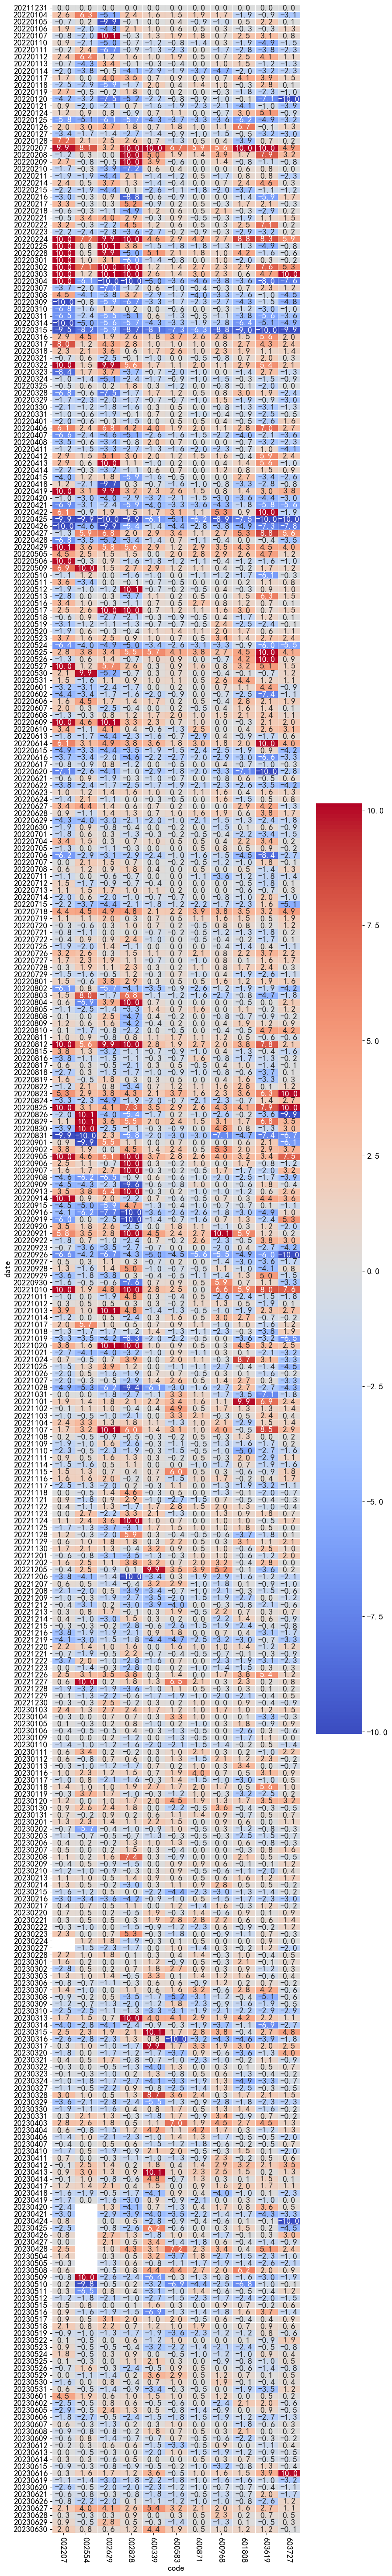

In [6]:

stock_trend = Stock_Trend(hy_source='sw_l2', block_name = '油服工程', end='2023-06-30', gap=360, frequence=QA.FREQUENCE.DAY, MA = 5)
stock_trend.fit()
stock_trend.plot()

In [ ]:
import tools.QAAdapter as qaadapter

import os

block_name = '通信设备'
block_name = '旅游景点'
block_name = '影视音像'
block_name = '电器仪表'
block_name = '软件服务'
# code_list  = qaadapter.QA_adapter_get_code_from_block('sw_l1', '国防军工')

block_name = '油服工程'
block_name = '家电零部件Ⅱ'
block_name = '化学纤维'
block_name = '游戏Ⅱ'
code_list  = qaadapter.QA_adapter_get_code_from_block('sw_l2', block_name)


block_name = '通信设备'
block_name = '旅游景点'
block_name = '影视音像'
block_name = '电器仪表'
block_name = '软件服务'
# code_list  = qaadapter.QA_adapter_get_code_from_block('tdxhy', '软件服务')

print(smpl.get_stock_name(code_list), len(code_list))

In [ ]:
from QUANTAXIS.QAAnalysis.QAAnalysis_finance import QAAnalysis_finance
from QUANTAXIS.QASetting.QALocalize import analysis_path
import os
# code_list = ['000408']
print("code list len ", len(code_list))
factors = ['roe', 'roa', 'profit_revenue', 'revenue_incr_rate', 'cash_incr_rate']
start = '2020-12-31'
end = '2023-03-31'
qaanalysis_finance = QAAnalysis_finance(code_list, factors,  start, end)
finance_factors = qaanalysis_finance.finance_factors_all_stock()
print(finance_factors)

csv_file = os.path.join(analysis_path, block_name + start + '_' + end + 'temp_finance_factors.csv')
finance_factors.to_csv(csv_file)

finance_rank = qaanalysis_finance.finance_factors_rank(finance_factors)

if finance_rank.empty:
  print("finance factors are None")
else:
  csv_file = os.path.join(analysis_path, block_name + start + '_' + end + '_finance.csv')
  print('finance_rank write to ', csv_file)
  finance_rank.to_csv(csv_file, index=True)

print(finance_rank)